## Load Libraries

In [1]:
# load libs and modules
import numpy as np
import pandas as pd
import get_data
import preprocess_data

# for VIF
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


/Users/stuartong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Define a regression Function

In [39]:
# import models to test
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def run_regression(defined_model, target, train_df,validate_df,test_df,additional_features_to_drop):

    # import preprocessing and evaluation metrics
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
    from yellowbrick.regressor import ResidualsPlot, PredictionError

    # columns to remove - target columns
    columns_to_drop = ['resale_price_norm',
                       'price_per_sq_ft_norm',
                       'price_per_sq_m_norm',
                       'price_per_sq_ft_per_lease_yr_norm',
                       'price_per_sq_m_per_lease_yr_norm',
                      ]
    targets = []
    targets.append(target)

    # additional columns to remove - from passed list
    if len(additional_features_to_drop) == 0:
        pass
    else:
        for feat in additional_features_to_drop:
            columns_to_drop.append(feat)            

    # get features and targets
    features = [x for x in train_df.columns.tolist() if x not in columns_to_drop]

    X_train = train_df[features]
    y_train = train_df[targets]
    X_test = test_df[features]
    y_test = test_df[targets]
    X_val = validate_df[features]
    y_val = validate_df[targets]

    # #scale and transform values
    sc = MinMaxScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_val = sc.transform(X_val)

    # fit and predict the model
    reg = defined_model
    reg.fit(X_train,y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    y_pred_val = reg.predict(X_val)

    # evaluate model
    # get R2 scores
    score_train = r2_score(y_train,y_pred_train)
    score_val = r2_score(y_val,y_pred_val)
    score_test = r2_score(y_test,y_pred_test)
    
    # get mse
    mse_train = mean_squared_error(y_train,y_pred_train)
    mse_val = mean_squared_error(y_val,y_pred_val)
    mse_test = mean_squared_error(y_test,y_pred_test)

    # print results
    r2_results = f'Dependent Variable:{target} \nR2 Scores: \nTrain:{score_train:.3f} \nValidation:{score_val:.3f}\nTest:{score_test:.3f}\nMSE: \nTrain:{mse_train:.3f}\nValidation:{mse_val:.3f} \nTest:{mse_test:.3f}\nIntercept:${reg.intercept_[0]:.2f}'
    print (r2_results)
    if str(type(reg)) == "<class 'sklearn.linear_model._base.LinearRegression'>":
        reg_coef = pd.DataFrame(reg.coef_,columns = features)
        
        # get residual plots
        # yellow brick only works with linear regressions it seems
        model = defined_model
        visualizer = ResidualsPlot(model)
        visualizer.fit(X_train, y_train)  
        visualizer.score(X_test, y_test)
        visualizer.show()
    else:
        reg_coef = pd.DataFrame(reg.coef_.reshape(1,-1),columns = features)



    return reg_coef.T.round(3).sort_values(by=0,ascending=False)

## Load Data from DB

This analysis is on resale transaction data WITHOUT additional location features

Train/Validate/Test Split - 60/20/20 by year
- Train: 1990 - 2006
- Validate: 2007 - 2013
- Test: 2014 - 2022

In [2]:
# get data without location features for baseline models - use all years

train_df,validate_df,test_df = get_data.get_data('resale_price_norm',1990,2006,2007,2013,2014)

Getting Training Data
Training Data Done
Getting Validate Data
Validate Data Done
Getting Test Data
Test Data Done


## Preprocess the data

We identify 3 main category columns:
- town
- flat_model
- flat_type

For now we load all the columns and One Hot Encode them

In [3]:

one_hot_encode = ['town','flat_type','flat_model']

train_df = preprocess_data.get_features_targets(train_df,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df,one_hot_encode)

## Run Regressions against all the variables

Ignoring the effects of multicollinearity

In [19]:
type(lr)

sklearn.linear_model._base.LinearRegression

Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.596 
Validation:0.269
Test:-724374047162220.625
MSE: 
Train:68.593
Validation:205.360 
Test:265627877958657984.000
Intercept:$49.93


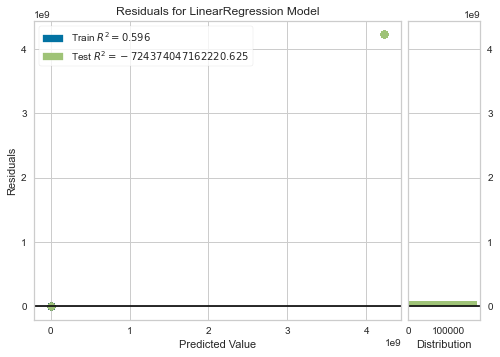

,0
n_rooms,7.310652e+12
flat_model_dbss,4.226232e+09
flat_model_terrace,4.506800e+01
town_marine_parade,1.995600e+01
town_central_area,1.364700e+01
flat_model_premium_maisonette,1.358100e+01
town_bishan,9.738000e+00
town_bukit_timah,9.289000e+00
town_bukit_merah,8.089000e+00
town_queenstown,5.903000e+00


In [7]:
# define model
lr = LinearRegression()
features_to_drop = []

run_regression(lr,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_to_drop)

### Check flat_type vs flat_model

Fields are similar - flat_model has more categories than flat_type which could be more descriptive potentially

Getting Training Data
Training Data Done
Getting Validate Data
Validate Data Done
Getting Test Data
Test Data Done
Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.567 
Validation:-1072908860500.507
Test:0.251
MSE: 
Train:73.475
Validation:301508716300289.750 
Test:274.670
Intercept:$42.75


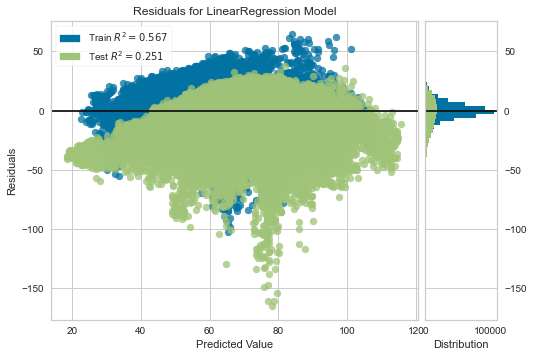

,0
n_rooms,1.534005e+12
storey_range_min,1.206517e+09
town_marine_parade,1.771800e+01
town_central_area,1.273700e+01
town_bishan,9.284000e+00
town_bukit_timah,8.455000e+00
town_bukit_merah,6.919000e+00
town_toa_payoh,4.338000e+00
town_queenstown,4.255000e+00
town_kallang_whampoa,3.819000e+00


In [8]:
# using flat_type

train_df,validate_df,test_df = get_data.get_data('resale_price_norm',1990,2006,2007,2013,2014)

one_hot_encode = ['town','flat_type']

train_df = preprocess_data.get_features_targets(train_df,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df,one_hot_encode)

# define model
lr = LinearRegression()
features_to_drop = []

run_regression(lr,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_to_drop)

Getting Training Data
Training Data Done
Getting Validate Data
Validate Data Done
Getting Test Data
Test Data Done
Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.594 
Validation:0.274
Test:0.315
MSE: 
Train:68.949
Validation:204.013 
Test:251.117
Intercept:$51.52
<class 'sklearn.linear_model._base.LinearRegression'>


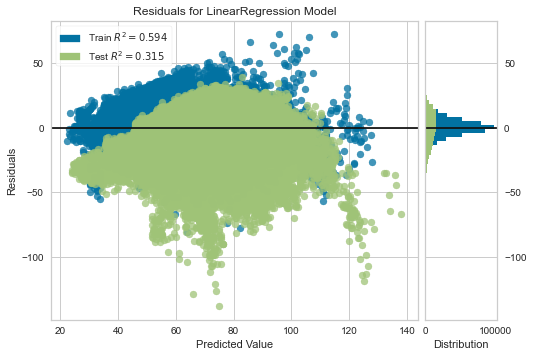

,0
n_rooms,61.790
flat_model_terrace,43.094
town_marine_parade,19.198
flat_model_premium_maisonette,14.202
town_central_area,13.106
town_bishan,9.541
town_bukit_timah,8.828
town_bukit_merah,7.627
flat_model_multi_generation,7.527
flat_model_maisonette,6.583


In [33]:
# using flat_model

train_df,validate_df,test_df = get_data.get_data('resale_price_norm',1990,2006,2007,2013,2014)

one_hot_encode = ['town','flat_model']

train_df = preprocess_data.get_features_targets(train_df,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df,one_hot_encode)

# define model
lr = LinearRegression()
features_to_drop = []

run_regression(lr,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_to_drop)

Getting Training Data
Training Data Done
Getting Validate Data
Validate Data Done
Getting Test Data
Test Data Done
Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.559 
Validation:0.247
Test:0.247
MSE: 
Train:74.947
Validation:211.643 
Test:275.952
Intercept:$49.78


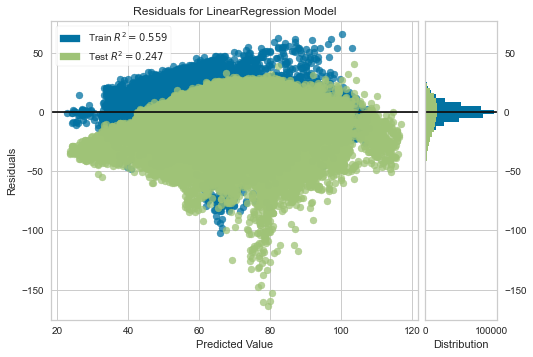

,0
n_rooms,29.482
floor_area_sqm,22.299
town_marine_parade,17.851
town_central_area,12.526
town_bishan,9.361
town_bukit_timah,8.661
town_bukit_merah,6.597
storey_range_max,4.986
storey_range_min,4.986
town_toa_payoh,4.484


In [80]:
# dropping both flat_model and flat_type

train_df,validate_df,test_df = get_data.get_data('resale_price_norm',1990,2006,2007,2013,2014)

one_hot_encode = ['town']

train_df = preprocess_data.get_features_targets(train_df,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df,one_hot_encode)

# define model
lr = LinearRegression()
features_to_drop = []

run_regression(lr,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_to_drop)

### Observations

Using flat_model appears to have better performance on validation and test when compared to flat_type and using both. However, there looks to be some overfitting going on so we should try with L1 and L2 regularization when running regressions

In [43]:
# test some lasso models
# Linear Regression Scores
# R2 Scores: 
# Train:0.594 
# Validation:0.274
# Test:0.315
# MSE: 
# Train:68.949
# Validation:204.013 
# Test:251.117

train_df,validate_df,test_df = get_data.get_data('resale_price_norm',1990,2006,2007,2013,2014)

one_hot_encode = ['town','flat_model']

train_df = preprocess_data.get_features_targets(train_df,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df,one_hot_encode)

# define lasso model - lower alpha is better but alpha = 0 is Linear Regression
model = Lasso(alpha=0.05,max_iter=5000)
features_to_drop = []

run_regression(model,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_to_drop)

Getting Training Data
Training Data Done
Getting Validate Data
Validate Data Done
Getting Test Data
Test Data Done
Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.552 
Validation:0.209
Test:0.204
MSE: 
Train:76.072
Validation:222.251 
Test:291.991
Intercept:$51.80


,0
n_rooms,34.944
town_marine_parade,14.326
town_bishan,9.271
storey_range_min,9.201
town_central_area,6.973
town_bukit_merah,6.329
town_toa_payoh,4.106
flat_model_maisonette,3.629
town_queenstown,3.501
town_kallang_whampoa,3.302


In [70]:
# Linear Regression Scores
# R2 Scores: 
# Train:0.594 
# Validation:0.274
# Test:0.315
# MSE: 
# Train:68.949
# Validation:204.013 
# Test:251.117


# define ridge model 
# higher alphas do marginally better on testset
model = Ridge(alpha=10,max_iter=1000)
features_to_drop = []

run_regression(model,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_to_drop)

Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.594 
Validation:0.274
Test:0.318
MSE: 
Train:68.960
Validation:204.128 
Test:250.144
Intercept:$53.31


,0
n_rooms,59.915
flat_model_terrace,39.601
town_marine_parade,19.212
town_central_area,13.144
flat_model_premium_maisonette,9.867
town_bishan,9.565
town_bukit_timah,8.805
town_bukit_merah,7.670
town_queenstown,5.425
storey_range_min,5.167


In [91]:
# Linear Regression Scores
# R2 Scores: 
# Train:0.594 
# Validation:0.274
# Test:0.315
# MSE: 
# Train:68.949
# Validation:204.013 
# Test:251.117


# define Elasticnet model 
# Similar to Lasso, lower alpha is better but alpha=0 is linear regression
# l1_ratio - L1 = 1 (l1 Penalty) L1 = 0 (L2 Penalty)

model = ElasticNet(alpha=0.0005,l1_ratio=0,max_iter=20000)
features_to_drop = []

run_regression(model,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_to_drop)

Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.558 
Validation:0.243
Test:0.244
MSE: 
Train:75.063
Validation:212.609 
Test:277.070
Intercept:$49.49


/Users/stuartong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19607518.807233047, tolerance: 8669.475185864843
  positive)


,0
n_rooms,30.097
floor_area_sqm,18.966
town_marine_parade,17.271
town_central_area,11.888
town_bishan,9.454
town_bukit_timah,7.733
town_bukit_merah,6.724
storey_range_min,5.008
storey_range_max,5.008
town_toa_payoh,4.676




## Check Correlations

- We use the traditional target of price per sq m normalized

In [ ]:
combined = pd.concat([train_df,test_df,validate_df],ignore_index=True)

# check correlations to 
corr_df = combined.corr()
corr_df = corr_df[['price_per_sq_m_norm']].sort_values(by='price_per_sq_m_norm')
print(corr_df.to_string())

Check correlations and multicollinearity before deciding what to drop

## Iteratively Check For Multicollinearity

In [ ]:
# Iteratively check for Multicollinearity

# exclude target variables
targets = [ 'resale_price_norm',
            'price_per_sq_ft_norm',
            'price_per_sq_ft_per_lease_yr_norm',
            'price_per_sq_m_norm',
            'price_per_sq_m_per_lease_yr_norm',]

# get initial features 
features = [x for x in combined.columns.tolist() if x not in targets]


def calc_vif(df,list_of_features):
    '''
    Function to check for multicollinearity
    '''
    from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[list_of_features])
    headers = df[list_of_features].columns.tolist()
    df = pd.DataFrame(scaled_data, columns=headers)

    # create VIF dataframe
    vif_df = pd.DataFrame()
    vif_df['feature'] = list_of_features
    vif_df['VIF'] = [variance_inflation_factor(df[list_of_features].values,i) for i in range(len(list_of_features))]

    return vif_df.round(3).sort_values(by='VIF',ascending=False)

calc_vif(combined,features)
    

### Iteration 1: 
Slightly counter intutive but VIF suggests that we have to remove n_rooms and storey_range_max

In [ ]:
features.remove('storey_range_max')
features.remove('n_rooms')
calc_vif(combined,features)

### Iteration 2:

VIF sugggests to drop remaining lease years as well - again slightly counter intutive but the intepretation is the flat_model and the town categories are sufficient to explain the age?

In [ ]:
features.remove('remaining_lease_years')
calc_vif(combined,features)

### Iteration 3:

Similarly size seems to also be explain by the flat_model and town. 

One way to look at it is that there are "periods" to building these flats - they typically launch flats of a specific type over a period of time in certain areas before opening new areas/new flat models. 

In [ ]:
features.remove('floor_area_sqm')
calc_vif(combined,features)

### Iteration 4:

We use 5 as our cut off which VIF suggest removing flat_model_model_a is the final iteration

In [ ]:
features.remove('flat_model_model_a')
calc_vif(combined,features)

### Iteration End

These features don't show a particularly high correlation to price per sq m but they seem to explain the variables we would expect to use:
- no or rooms
- size
- remaining lease years

For the next run, we should try a regression WITHOUT the categorical variables and compare model accuracies.

In [ ]:
# import models to test
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def run_regression(defined_model, target, train_df,test_df,validate_df):

    # import preprocessing and evaluation metrics
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
    from yellowbrick.regressor import ResidualsPlot, PredictionError

    columns_to_drop = ['resale_price_norm',
                       'price_per_sq_ft_norm',
                       'price_per_sq_m_norm',
                       'price_per_sq_ft_per_lease_yr_norm',
                       'price_per_sq_m_per_lease_yr_norm',
                      ]
    targets = []
    targets.append(target)

    # get features and targets
    features = [x for x in train_df.columns.tolist() if x not in columns_to_drop]

    
    X_train = train_df[features]
    y_train = train_df[targets]
    X_test = test_df[features]
    y_test = test_df[targets]
    X_val = validate_df[features]
    y_val = validate_df[targets]

    # #scale and transform values
    # sc = MinMaxScaler()
    # X_train = sc.fit_transform(X_train)
    # X_test = sc.transform(X_test)
    # X_val = sc.transform(X_val)

    # fit and predict the model
    reg = defined_model
    reg.fit(X_train,y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    y_pred_val = reg.predict(X_val)

    # evaluate model
    # get R2 scores
    score_train = r2_score(y_train,y_pred_train)
    score_test = r2_score(y_test,y_pred_test)
    score_val = r2_score(y_val,y_pred_val)

    # get mse
    mse_train = mean_squared_error(y_train,y_pred_train)
    mse_test = mean_squared_error(y_test,y_pred_test)
    mse_val = mean_squared_error(y_val,y_pred_val)

    # print results
    r2_results = f'Dependent Variable:{target} \nR2 Scores: \nTrain:{score_train:.3f} \nTest:{score_test:.3f}\nValidation:{score_val:.3f}\nMSE: \nTrain:{mse_train:.3f} \nTest:{mse_test:.3f}\nValidation:{mse_val:.3f}\nIntercept:${reg.intercept_[0]:.2f}'
    print (r2_results)
    reg_coef = pd.DataFrame(reg.coef_,columns = features)
    


    # get residual plots
    model = defined_model
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()

    return reg_coef.T.round(3).sort_values(by=0,ascending=False)
    


In [ ]:
# define some models
lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()
elastic = ElasticNet()

### Run Regressions Against Different Target Variables

In [ ]:
run_regression(lr,'resale_price_norm',train_df,test_df,validate_df)

In [ ]:
run_regression(lr,'price_per_sq_m_norm',train_df,test_df,validate_df)

In [ ]:
run_regression(lr,'price_per_sq_m_per_lease_yr_norm',train_df,test_df,validate_df)